In [16]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from scipy.signal import find_peaks

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mlp import MLP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.visuals import get_twod_grid
import json 

from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

color_blindf = ["#1F77B4", "#AEC7E8", "#FF7F0E", "#FFBB78", 
                "#2CA02C", "#98DF8A", "#D62728", "#FF9896", 
                "#9467BD", "#C5B0D5", "#8C564B",  "#C49C94", 
                "#E377C2", "#F7B6D2", "#7F7F7F", "#C7C7C7", 
                "#BCBD22", "#DBDB8D", "#17BECF", "#9EDAE5"
                ]

In [17]:
DATA_DIR = "./output/"
ITERATION = 7
with open('/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

In [18]:
# Load trained MLP model for p(z|c)
train_x = torch.load(DATA_DIR+'/train_x_%d.pt'%ITERATION, map_location=device)
train_z_mean = torch.load(DATA_DIR+'/train_z_mean_%d.pt'%ITERATION, map_location=device)
train_z_std = torch.load(DATA_DIR+'/train_z_std_%d.pt'%ITERATION, map_location=device)
mlp = MLP(train_x, train_z_mean, train_z_std)
mlp_state_dict = torch.load(DATA_DIR+'/comp_model_%d.pt'%(ITERATION), map_location=device)
mlp.load_state_dict(mlp_state_dict)

# Load trained NP model for p(y|z)
NP = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
NP.load_state_dict(torch.load(DATA_DIR+'/np_model_%d.pt'%(ITERATION), map_location=device))

design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

In [19]:
def from_comp_to_spectrum(t, c, comp_model, np_model):
    ci = torch.tensor(c).to(device)
    z_mu, z_std = comp_model.mlp(ci)
    z_dist = torch.distributions.Normal(z_mu, z_std)
    z = z_dist.sample(torch.Size([100]))
    t = torch.from_numpy(t).repeat(100, 1, 1).to(device)
    t = torch.swapaxes(t, 1, 2)
    y_samples, _ = np_model.xz_to_y(t, z)

    mean_pred = y_samples.mean(dim=0, keepdim=True)
    sigma_pred = y_samples.std(dim=0, keepdim=True)
    mu_ = mean_pred.cpu().squeeze()
    sigma_ = sigma_pred.cpu().squeeze() 

    return mu_, sigma_

In [20]:
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (11, 2) (11, 101)
Loading data from iteration 2 with shapes: (11, 2) (11, 101)
Loading data from iteration 3 with shapes: (11, 2) (11, 101)
Loading data from iteration 4 with shapes: (11, 2) (11, 101)
Loading data from iteration 5 with shapes: (11, 2) (11, 101)
Loading data from iteration 6 with shapes: (11, 2) (11, 101)


In [21]:
grid_comps = get_twod_grid(20, expt.bounds.cpu().numpy())
grid_spectra = np.zeros((grid_comps.shape[0], len(expt.t)))
with torch.no_grad():
    for i, ci in enumerate(grid_comps):
        mu, sigma = from_comp_to_spectrum(expt.t, ci, mlp, NP)
        mu_ = mu.cpu().squeeze().numpy()
        grid_spectra[i, :] = mu_ 

In [22]:
# rid = np.random.choice(np.arange(grid_comps.shape[0]))
# # rid = 255
# for rid in range(grid_comps.shape[0]):
#     y = grid_spectra[rid, :]
#     y_norm = (y-min(y))/(max(y)-min(y))
#     # peaks, properties = find_peaks(y, prominence=0.001, width=0.01)
#     peaks, properties = find_peaks(y_norm)
#     fig, ax = plt.subplots()
#     ax.plot(expt.wl, y_norm)
#     print("peak are at : ", expt.wl[peaks])
#     for p in peaks:
#         ax.axvline(x=expt.wl[p].item(), color="k")
#     plt.show()

In [23]:
# define rules for phasemap
def featurize_spectra_peaks(y):
    y_norm = (y-min(y))/(max(y)-min(y))
    peaks, properties = find_peaks(y_norm)
    if len(peaks)==1:
        if y_norm[-1]>0.5:
            out = 2
        else:
            out = 0
    else:
        if y_norm[peaks[-1]]>0.2:
            out = 1
        else:
            out = 0
    
    return out

features = []
for i, si in enumerate(grid_spectra):
    features.append(featurize_spectra_peaks(si))
features = np.asarray(features)

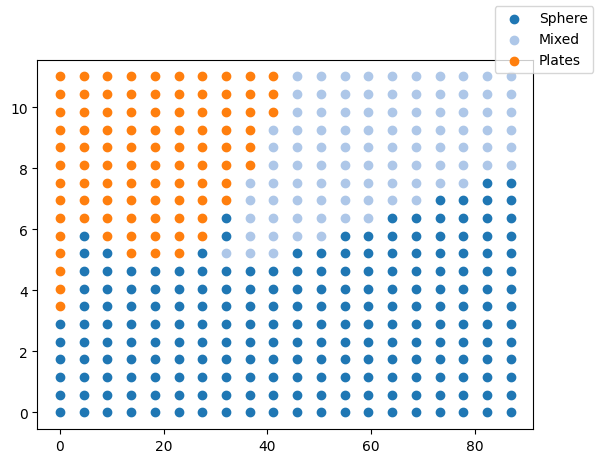

In [24]:
fig, ax = plt.subplots()
labels = ["Sphere", "Mixed", "Plates"]
for i in range(3):
    ax.scatter(grid_comps[features==i, 0],
               grid_comps[features==i, 1],
               color = color_blindf[i],
               label = labels[i]
               )
fig.legend()
plt.show()

In [25]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    
    return ax

In [26]:
import gpytorch
import torch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def _fit_gp_model(train_x, train_y, model, likelihood, training_iter=200):
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        if (i % 50 == 0) or (i==training_iter-1):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

    return model, likelihood

def get_phasemap_plot_vars(grid_comps, grid_spectra, labels, **kwargs):
    train_x = torch.Tensor(grid_comps)
    train_y = torch.Tensor(labels).long().squeeze()

    # initialize likelihood and model
    # we let the DirichletClassificationLikelihood compute the targets for us
    likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
    model = DirichletGPModel(train_x,
                             likelihood.transformed_targets,
                             likelihood,
                             num_classes=likelihood.num_classes
                             )
    model, likelihood = _fit_gp_model(train_x,
                                      train_y,
                                      model,
                                      likelihood,
                                      training_iter=200
                                      )

    n_grid_points = kwargs.get("n_grid_points", 30)
    test_d1 = np.linspace(grid_comps[:,0].min(), grid_comps[:,0].max(), n_grid_points)
    test_d2 = np.linspace(grid_comps[:,1].min(), grid_comps[:,1].max(), n_grid_points)
    test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
    test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

    test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

    model.eval()
    likelihood.eval()

    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        test_dist = model(test_x)

    pred_samples = test_dist.sample(torch.Size((256,))).exp()
    probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

    return probabilities, test_x_mat, test_y_mat

probabilities, test_x_mat, test_y_mat = get_phasemap_plot_vars(grid_comps, grid_spectra, features)

Iter 1/200 - Loss: 11.508   lengthscale: 0.693   noise: 0.693
Iter 51/200 - Loss: 5.868   lengthscale: 3.398   noise: 0.261
Iter 101/200 - Loss: 5.742   lengthscale: 3.806   noise: 0.052
Iter 151/200 - Loss: 5.712   lengthscale: 3.895   noise: 0.029
Iter 200/200 - Loss: 5.698   lengthscale: 3.957   noise: 0.019


/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1487/1967543172.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


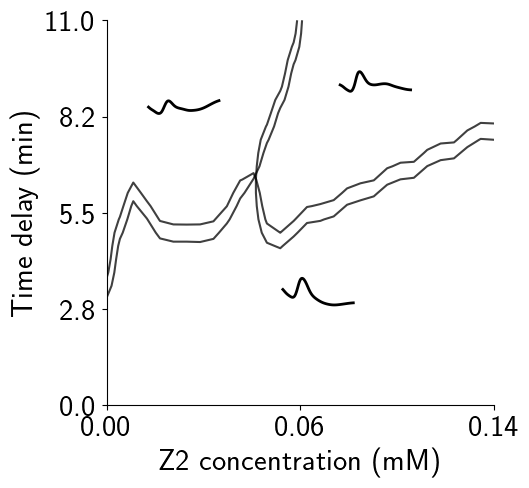

In [27]:
def plot_phasemap(ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    min_prob = kwargs.get("min_prob", 0.3)
    n_clusters = len(np.unique(features))

    for k in range(n_clusters):
        flags = features==k
        comps_k_mean = np.mean(grid_comps[flags,:], axis=0)
        spectra_k_mean = np.mean(grid_spectra[flags,:], axis=0)
        norm_ci = (comps_k_mean-grid_comps.min(axis=0))/((grid_comps.max(axis=0)-grid_comps.min(axis=0)))
        loc_ax = ax.transLimits.transform(norm_ci)
        ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
        ins_ax.plot(expt.wl, spectra_k_mean, color="k", lw=2.0)
        ins_ax.set_ylim([0, 1.5])
        ins_ax.axis("off")
    n_grid_points = kwargs.get("n_grid_points", 30)
    for k in range(n_clusters):
        ax.contour(test_x_mat.numpy(),
                    test_y_mat.numpy(),
                    probabilities[k].numpy().reshape((n_grid_points,n_grid_points)),
                    levels=[min_prob, 1.0],
                    colors="k",
                    alpha=kwargs.get("alpha", 0.75)
                    )
    return 

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    plot_phasemap(ax = ax, min_prob = 0.35)
    prettify_axis(ax)
    plt.show()

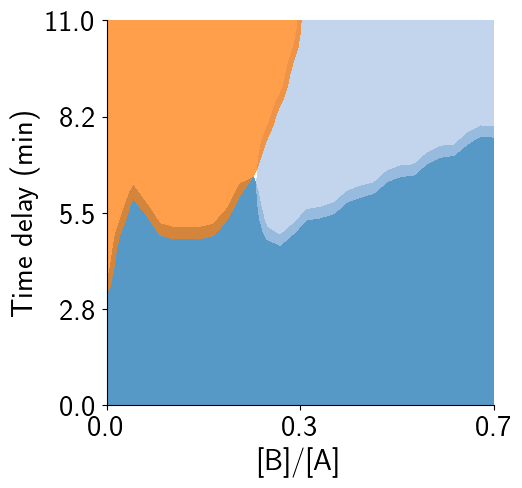

In [28]:
# Plot phase map with x-axis as concentration ratio
fixed_volumes = [54, 87, 13]
V_total = 280 
plot_x = np.zeros_like(grid_comps)
plot_x[:,1] = grid_comps[:,1]

B_conc = (0.3*grid_comps[:,0])/280
A_conc = (0.3*87)/(abs(grid_comps[:,0]-280))
plot_x[:,0] = B_conc/A_conc

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    test_d1 = np.linspace(plot_x[:,0].min(), plot_x[:,0].max(), 30)
    test_d2 = np.linspace(plot_x[:,1].min(), plot_x[:,1].max(), 30)
    test_x_mat_, test_y_mat_ = np.meshgrid(test_d1, test_d2)

    for k in range(3):
        ax.contourf(test_x_mat_, test_y_mat_,
                    probabilities[k].numpy().reshape((30,30)),
                    levels=[0.4, 1.0],
                    colors=color_blindf[k],
                    alpha=0.75
                    )
    ax.set_xlabel('[B]/[A]')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(min(plot_x[:,0]), max(plot_x[:,0]))
    ax.set_ylim(min(plot_x[:,1]), max(plot_x[:,1]))
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    plt.savefig("./figures/phasemap_ratio.png")
    plt.show()


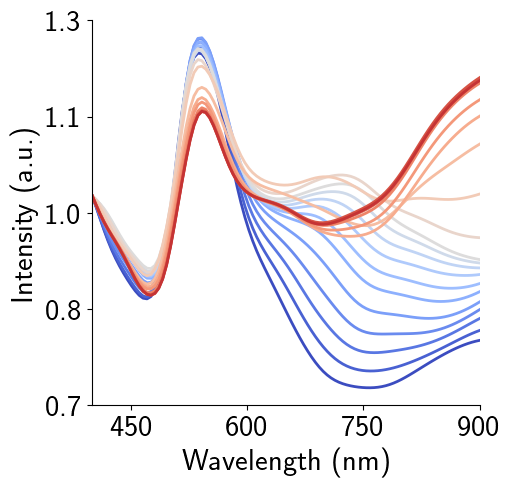

In [31]:
# Generate spectra along a line 
points = np.asarray([[70.0, 4.0], [20.0, 10.0]])
n_line_samples=20
xs=np.linspace(points[0,0], points[1,0], n_line_samples)
ys=np.linspace(points[0,1], points[1,1], n_line_samples)
line_comps = np.vstack((xs, ys)).T
with torch.no_grad():
    line_spectra = np.zeros((n_line_samples, expt.n_domain))
    for i,ci in enumerate(line_comps):
        mu, sigma = from_comp_to_spectrum(expt.t, ci, mlp, NP)
        line_spectra[i,:] = mu.cpu().squeeze()

def plot_along_line(ax):
    # cmap = LinearSegmentedColormap.from_list('line_cont_cmap', 
    #                                         [(0,    color_blindf[0]),
    #                                         (0.25, color_blindf[1]),
    #                                         (1,    color_blindf[2])], 
    #                                         N=n_line_samples
    #                                         )
    cmap = plt.get_cmap("coolwarm")
    norm = Normalize(vmin=0, vmax = n_line_samples)
    ax.set_xlim([400.0, 900.0])
    for i in range(n_line_samples):
        y = line_spectra[i,:]
        y_norm = y/y[0]
        ax.plot(expt.wl, y_norm, color=cmap(norm(i)), lw=2.0)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity (a.u.)")

    return ax

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    plot_along_line(ax)
    plt.savefig("./figures/linesample.png")
    plt.show()

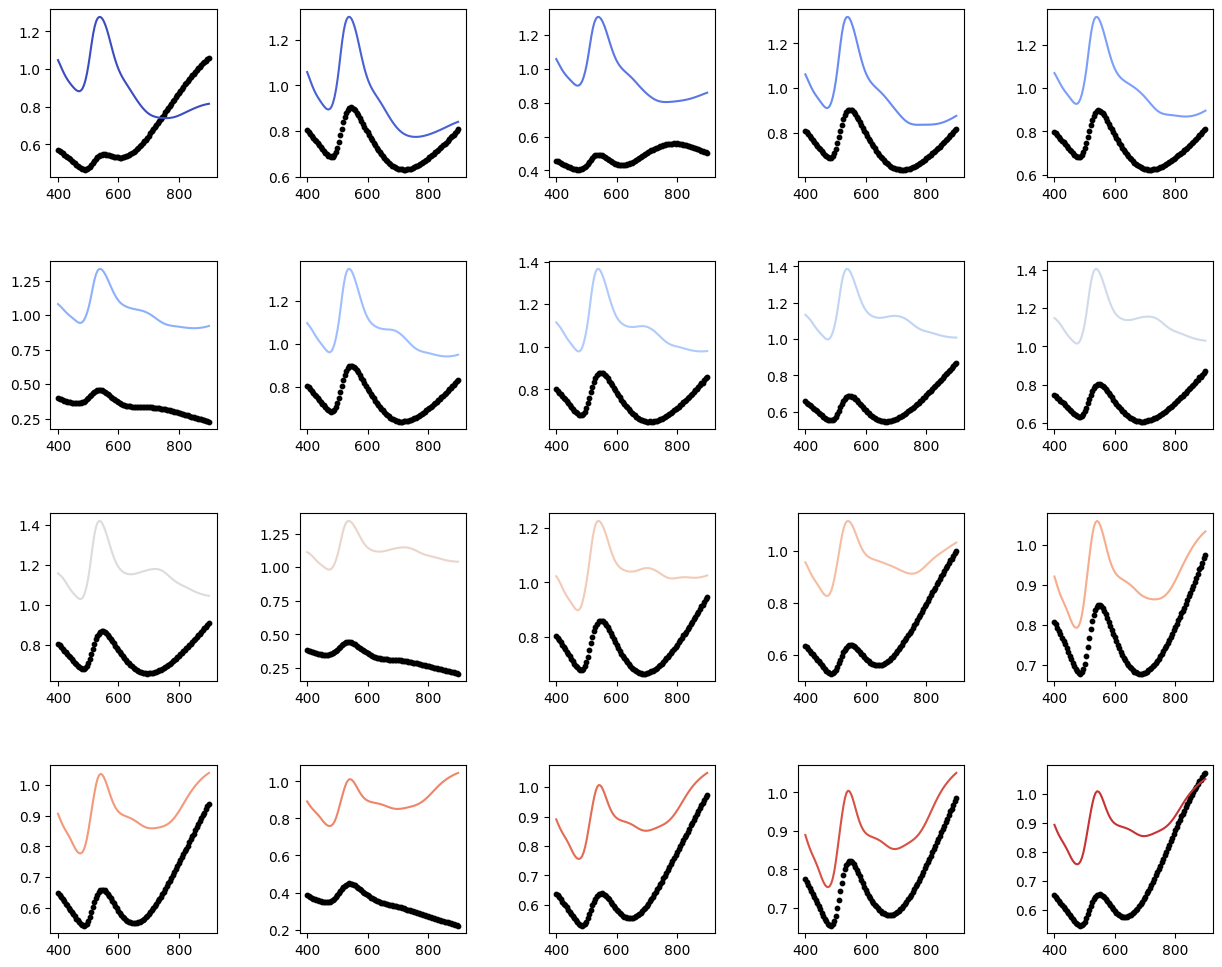

In [42]:
# Compare line sample prediction with measured
cmap = plt.get_cmap("coolwarm")
norm = Normalize(vmin=0, vmax = n_line_samples)
linesample_measured = np.load("../line_sample_validation/uvvis.npz")
fig, axs = plt.subplots(4,5, figsize=(3*5, 3*4))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.scatter(linesample_measured["wavelength"],
            linesample_measured["spectra"][i,:],
            color="k",
            s = 10
            )
    ax.plot(expt.wl, line_spectra[i,:], color=cmap(norm(i)))
plt.show()
    

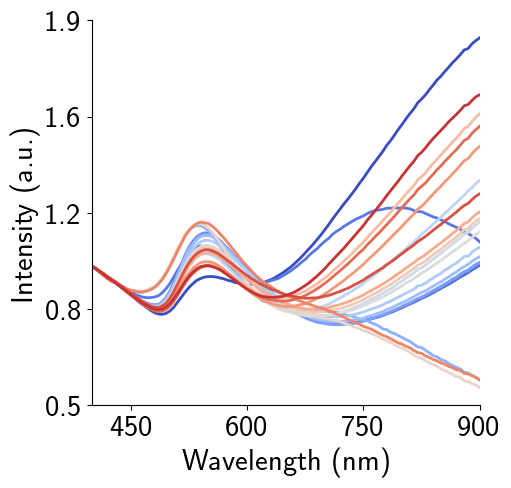

In [43]:
def plot_measured_line_samples(ax):
    cmap = plt.get_cmap("coolwarm")
    norm = Normalize(vmin=0, vmax = n_line_samples)
    ax.set_xlim([400.0, 900.0])
    for i in range(n_line_samples):
        y = linesample_measured["spectra"][i,:]
        y_norm = y/y[0]
        ax.plot(linesample_measured["wavelength"], 
                y_norm, 
                color=cmap(norm(i)), lw=2.0
                )
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity (a.u.)")

    return ax 

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    plot_measured_line_samples(ax)
    plt.savefig("./figures/linesample_measured.png")
    plt.show()   

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1487/1967543172.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


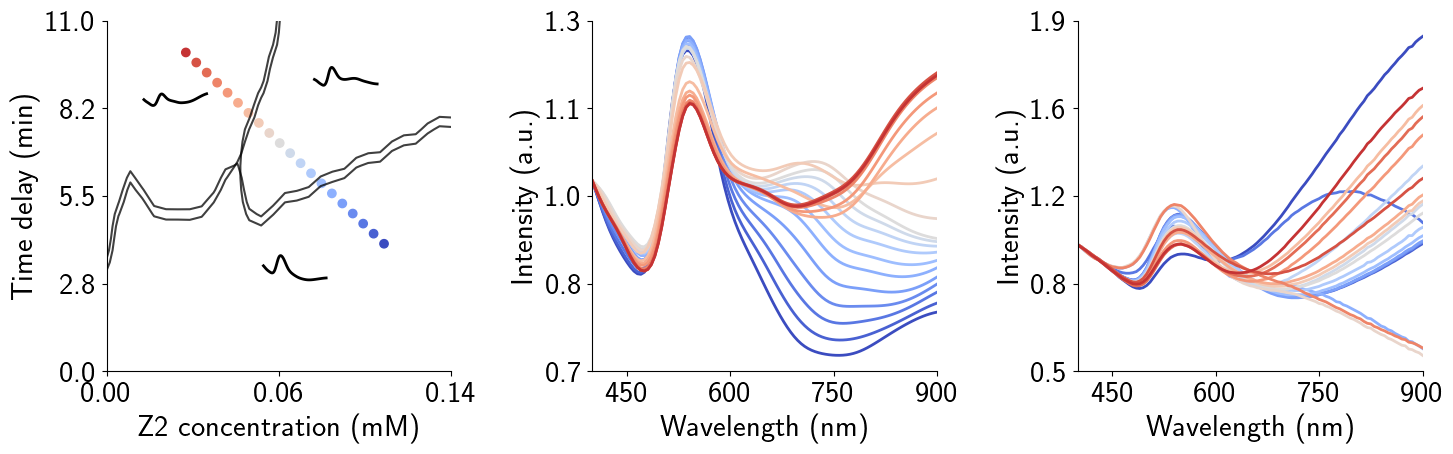

In [44]:
with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(1,3, figsize=(5*3, 5*1))
    plot_phasemap(ax = axs[0], min_prob = 0.4)
    prettify_axis(axs[0])
    cmap = plt.get_cmap("coolwarm")
    norm = Normalize(vmin=0, vmax = n_line_samples)
    axs[0].scatter(line_comps[:,0], line_comps[:,1], 
                   c = np.arange(n_line_samples),
                   cmap = cmap, norm = norm
                   )
    plot_along_line(axs[1])
    plot_measured_line_samples(axs[2])
    plt.tight_layout()
    plt.savefig("./figures/phasemap_and_linesample.png")
    plt.show()

## Pesuedo-code for showing retrosynthesis


```python
def simulator(c, x):
    # 1. Compute latent variable
    z_mu, z_std = mlp(c)

    # 2. Sample z valeues from Normal distribution
    z_dist = Normal(z_mu, z_std)
    z = z_dist.samples(100)

    # 3. Sample spectra from decoder
    y_samples = NP(x, z)

    # 4. Obtain mean and std from samples
    mu = y_samples.mean()
    std = y_samples.std()

    return mu, std
```

Following is used for stochastic optimization:

```python
# Start from a random sample in the design space
c = random_samples()

while error<1e-2:
    # 1. Predict the spectrum at current location
    y_predicted,_ = simulator(c)

    # 2. Compute error value wrto target
    error = mse_loss(y_target, y_predicted)

    # 3. Compute gradient using autodiff
    grad_ = error.grad()

    # Make a gradient descent step
    c -= 0.01*grad_

```

```bash
pip install pyGDM2
```